# GNN Decoder for BCH Codes

This notebook reproduces the (63,45) BCH results in the paper [Graph Neural Networks for Channel Decoding](https://arxiv.org/pdf/2207.14742.pdf).

**Remark**: the training can take several hours. However, pre-trained weights are stored in this repository and can be directly loaded to reproduce the results.

This notebook requires [Sionna](https://nvlabs.github.io/sionna/).

In [1]:
# general imports
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# load required Sionna components
from sionna.fec.utils import load_parity_check_examples, LinearEncoder, gm2pcm
from sionna.utils.plotting import PlotBER
from sionna.fec.ldpc import LDPCBPDecoder

%load_ext autoreload
%autoreload 2
from gnn import * # load GNN functions
from wbp import * # load weighted BP functions

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 2
Only GPU number 0 used.


## Define Hyperparameters and Load Code

We define all parameters as dictionary to support different architectures for different codes.


In [21]:
#----- BCH -----
params={
    # --- Code Parameters ---
        "code": "BCH", # (63,45)
    # --- GNN Architecture ----
        "num_embed_dims": 20,
        "num_msg_dims": 20,
        "num_hidden_units": 40,
        "num_mlp_layers": 2,
        "num_iter": 8,
        "reduce_op": "mean",
        "activation": "tanh",
        "clip_llr_to": None,
        "use_attributes": False,
        "node_attribute_dims": 0,
        "msg_attribute_dims": 0,
        "use_bias": False,        
    # --- Training ---- # 
        "batch_size": [256, 256, 256], # bs, iter, lr must have same dim
        "train_iter": [35000, 300000, 300000],
        "learning_rate": [1e-3, 1e-4, 1e-5],
        "ebno_db_train": [3, 8.],
        "ebno_db_eval": 4.,          
        "batch_size_eval": 10000, # batch size only used for evaluation during training
        "eval_train_steps": 1000, # evaluate model every N iters
    # --- Log ----
        "save_weights_iter": 10000, # save weights every X iters
        "run_name": "BCH_01", # name of the stored weights/logs
        "save_dir": "results/", # folder to store results
    # --- MC Simulation parameters ----
        "mc_iters": 1000,
        "mc_batch_size": 2000,
        "num_target_block_errors": 500,
        "ebno_db_min": 2.,
        "ebno_db_max": 9.,
        "ebno_db_stepsize": 1.,
        "eval_iters": [2, 3, 4, 6, 8, 10],        
    # --- Weighted BP parameters ----
        "simulate_wbp": True, # simulate weighted BP as baseline
        "wbp_batch_size" : [2000, 2000, 2000],
        "wbp_train_iter" : [300, 10000, 2000],
        "wbp_learning_rate" : [1e-2, 1e-3, 1e-3],
        "wbp_ebno_train" : [5., 5., 6.],
        "wbp_ebno_val" : 7., # validation SNR during training
        "wbp_batch_size_val" : 2000,
        "wbp_clip_value_grad" : 10, 
}

## Load / Generate the Graph

In [4]:
# all codes must provide an encoder-layer and a pcm
if params["code"]=="BCH":    
    print("Loading BCH code")
    pcm, k, n, coderate = load_parity_check_examples(pcm_id=1, verbose=True)

    encoder = LinearEncoder(pcm, is_pcm=True)
    params["k"] = k
    params["n"] = n
else:
    raise ValueError("Unknown code type")

Loading BCH code

n: 63, k: 45, coderate: 0.714


## Simulate Baseline BER Performance

In [5]:
ber_plot = PlotBER(f"GNN-based Decoding - {params['code']}, (k,n)=({k},{n})")
ebno_dbs = np.arange(params["ebno_db_min"],
                     params["ebno_db_max"]+1,
                     params["ebno_db_stepsize"])

In [6]:
# uncoded QPSK
e2e_uncoded = E2EModel(None, None, k=100, n=100) # k and n are not relevant here
ber_plot.simulate(e2e_uncoded,
                  ebno_dbs=ebno_dbs,
                  batch_size=params["mc_batch_size"],
                  num_target_block_errors=params["num_target_block_errors"],
                  legend="Uncoded",
                  soft_estimates=True,
                  max_mc_iter=params["mc_iters"],
                  forward_keyboard_interrupt=False,
                  show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 3.8070e-02 | 9.8100e-01 |        7614 |      200000 |         1962 |        2000 |         1.7 |reached target block errors
      3.0 | 2.2660e-02 | 9.0350e-01 |        4532 |      200000 |         1807 |        2000 |         0.0 |reached target block errors
      4.0 | 1.2430e-02 | 7.2000e-01 |        2486 |      200000 |         1440 |        2000 |         0.0 |reached target block errors
      5.0 | 5.8450e-03 | 4.4000e-01 |        1169 |      200000 |          880 |        2000 |         0.0 |reached target block errors
      6.0 | 2.3225e-03 | 2.1000e-01 |         929 |      400000 |          840 |        4000 |         0.0 |reached target block errors
      7.0 | 7.6875e-04 | 7.3750e-02 |         615 |      800000 |

In [7]:
# simulate "conventional" BP performance for given pcm
bp_decoder = LDPCBPDecoder(pcm, num_iter=20, hard_out=False)
e2e_bp = E2EModel(encoder, bp_decoder, k, n)
ber_plot.simulate(e2e_bp,
                 ebno_dbs=ebno_dbs,
                 batch_size=params["mc_batch_size"],
                 num_target_block_errors=params["num_target_block_errors"],
                 legend=f"BP {bp_decoder._num_iter.numpy()} iter.",
                 soft_estimates=True,
                 max_mc_iter=params["mc_iters"],
                 forward_keyboard_interrupt=False,
                 show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 5.9905e-02 | 7.9250e-01 |        7548 |      126000 |         1585 |        2000 |         2.6 |reached target block errors
      3.0 | 3.2103e-02 | 4.9700e-01 |        4045 |      126000 |          994 |        2000 |         0.0 |reached target block errors
      4.0 | 1.4429e-02 | 2.2000e-01 |        3636 |      252000 |          880 |        4000 |         0.0 |reached target block errors
      5.0 | 4.8214e-03 | 6.7000e-02 |        2430 |      504000 |          536 |        8000 |         0.0 |reached target block errors
      6.0 | 9.0136e-04 | 1.2000e-02 |        2385 |     2646000 |          504 |       42000 |         0.1 |reached target block errors
      7.0 | 1.4827e-04 | 2.0040e-03 |        2354 |    15876000 |

In [ ]:
# train and simulate Weighted BP as additional baseline
# please note that the training parameters could be critical 
if params["simulate_wbp"]:
    evaluate_wbp(params, pcm, encoder, ebno_dbs, ber_plot)

Iter: 0 loss: 0.002266 ber: 0.000103 bmi: 0.999
Iter: 50 loss: 0.001587 ber: 0.000071 bmi: 0.999
Iter: 100 loss: 0.002758 ber: 0.000095 bmi: 0.999
Iter: 150 loss: 0.001674 ber: 0.000167 bmi: 0.999
Iter: 200 loss: 0.001780 ber: 0.000063 bmi: 0.999
Iter: 250 loss: 0.000699 ber: 0.000079 bmi: 0.999
Iter: 0 loss: 0.000548 ber: 0.000040 bmi: 1.000
Iter: 50 loss: 0.000799 ber: 0.000024 bmi: 1.000
Iter: 100 loss: 0.000624 ber: 0.000040 bmi: 1.000
Iter: 150 loss: 0.000912 ber: 0.000095 bmi: 1.000
Iter: 200 loss: 0.000690 ber: 0.000056 bmi: 1.000
Iter: 250 loss: 0.001479 ber: 0.000079 bmi: 0.999
Iter: 300 loss: 0.000545 ber: 0.000063 bmi: 1.000
Iter: 350 loss: 0.000755 ber: 0.000048 bmi: 1.000
Iter: 400 loss: 0.000490 ber: 0.000032 bmi: 1.000
Iter: 450 loss: 0.000761 ber: 0.000095 bmi: 0.999
Iter: 500 loss: 0.000970 ber: 0.000079 bmi: 0.999
Iter: 550 loss: 0.000706 ber: 0.000063 bmi: 1.000
Iter: 600 loss: 0.000787 ber: 0.000056 bmi: 0.999
Iter: 650 loss: 0.000491 ber: 0.000032 bmi: 1.000
Iter: 

### GNN-based Decoding


In [12]:
tf.random.set_seed(2) # we fix the seed to ensure stable convergence 

# init the GNN decoder
gnn_decoder = GNN_BP(pcm=pcm,
                     num_embed_dims=params["num_embed_dims"],
                     num_msg_dims=params["num_msg_dims"],
                     num_hidden_units=params["num_hidden_units"],
                     num_mlp_layers=params["num_mlp_layers"],
                     num_iter=params["num_iter"],
                     reduce_op=params["reduce_op"],
                     activation=params["activation"],
                     output_all_iter=True,
                     clip_llr_to=params["clip_llr_to"],
                     use_attributes=params["use_attributes"],
                     node_attribute_dims=params["node_attribute_dims"],
                     msg_attribute_dims=params["msg_attribute_dims"],
                     use_bias=params["use_bias"])
                     
e2e_gnn = E2EModel(encoder, gnn_decoder, k, n)

In [13]:
# init model and print summary
e2e_gnn(1, 1.)
e2e_gnn.summary()

Model: "e2e_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 binary_source_4 (BinarySour  multiple                 0         
 ce)                                                             
                                                                 
 mapper_4 (Mapper)           multiple                  0         
                                                                 
 demapper_4 (Demapper)       multiple                  0         
                                                                 
 awgn_4 (AWGN)               multiple                  0         
                                                                 
 gnn_bp_1 (GNN_BP)           multiple                  9640      
                                                                 
 linear_encoder (LinearEncod  multiple                 0         
 er)                                                   

and let's train the model

In [15]:
train = False # remark: training takes several hours
if train:
    train_gnn(e2e_gnn, params)
else:
    # you can also load the precomputed weights
    load_weights(e2e_gnn, "weights/BCH_precomputed.npy")

## Evaluate Final Performance

and store results...

In [ ]:
for iters in params["eval_iters"]:
    # instantiate new decoder for each number of iter (otherwise no retracing)
    gnn_dec_temp = GNN_BP(pcm=pcm,
                          num_embed_dims=params["num_embed_dims"],
                          num_msg_dims=params["num_msg_dims"],
                          num_hidden_units=params["num_hidden_units"],
                          num_mlp_layers=params["num_mlp_layers"],
                          num_iter=iters,
                          reduce_op=params["reduce_op"],
                          activation=params["activation"],
                          output_all_iter=False,
                          clip_llr_to=params["clip_llr_to"],
                          use_attributes=params["use_attributes"],
                          node_attribute_dims=params["node_attribute_dims"],
                          msg_attribute_dims=params["msg_attribute_dims"],
                          use_bias=params["use_bias"])    
    # generate new model   
    model = E2EModel(encoder, gnn_dec_temp, k, n)
    model(1,1.) # init model
    # copy weights from trained decoder
    model._decoder.set_weights(gnn_decoder.get_weights())

    # and run the BER simulations
    ber_plot.simulate(model,
                     ebno_dbs=ebno_dbs,
                     batch_size=params["mc_batch_size"],
                     num_target_block_errors=500,
                     legend=f"GNN {iters} iter.",
                     soft_estimates=True,
                     max_mc_iter=params["mc_iters"],
                     forward_keyboard_interrupt=False,
                     show_fig=False);

ber_plot(xlim=[2,9],ylim=[1e-5,0.1]) # show final figure

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 6.3865e-02 | 9.3100e-01 |        8047 |      126000 |         1862 |        2000 |         3.8 |reached target block errors
      3.0 | 4.0619e-02 | 7.7550e-01 |        5118 |      126000 |         1551 |        2000 |         0.0 |reached target block errors
      4.0 | 1.9635e-02 | 4.7750e-01 |        2474 |      126000 |          955 |        2000 |         0.0 |reached target block errors
      5.0 | 6.8294e-03 | 2.0275e-01 |        1721 |      252000 |          811 |        4000 |         0.0 |reached target block errors
      6.0 | 1.5206e-03 | 5.4400e-02 |         958 |      630000 |          544 |       10000 |         0.1 |reached target block errors
      7.0 | 2.7088e-04 | 1.1283e-02 |         785 |     2898000 |

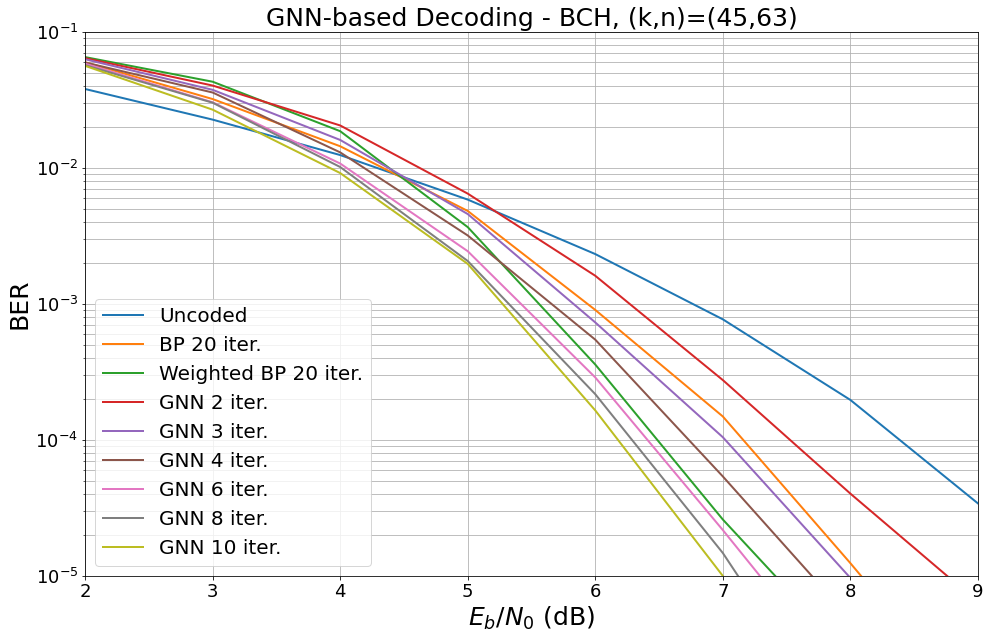

In [25]:
ber_plot(xlim=[2,9],ylim=[1e-5,0.1]) # show final figure

In [ ]:
# export results for pgf plots
col_names = ["uncoded",  "bp-20"]
if params["simulate_wbp"]:
    col_names.append("wbp-20")
for it in params["eval_iters"]:
    col_names.append("gnn-" + str(it))
export_pgf(ber_plot, col_names)

snr, 	uncoded, 	bp-20, 	wbp-20, 	gnn-2, 	gnn-3, 	gnn-4, 	gnn-6, 	gnn-8, 	gnn-10, 	
2.000,	3.807000E-02,	5.990476E-02,	6.537302E-02,	6.427778E-02,	6.301587E-02,	5.967460E-02,	5.848413E-02,	5.702381E-02,	5.632540E-02,	
3.000,	2.266000E-02,	3.210317E-02,	4.306349E-02,	4.035714E-02,	3.753968E-02,	3.586508E-02,	3.038889E-02,	3.017460E-02,	2.681746E-02,	
4.000,	1.243000E-02,	1.442857E-02,	1.862698E-02,	2.052381E-02,	1.605556E-02,	1.300794E-02,	1.076984E-02,	1.015079E-02,	9.162698E-03,	
5.000,	5.845000E-03,	4.821429E-03,	3.666667E-03,	6.468254E-03,	4.575397E-03,	3.182540E-03,	2.438095E-03,	2.064815E-03,	1.965608E-03,	
6.000,	2.322500E-03,	9.013605E-04,	3.574165E-04,	1.607937E-03,	7.293651E-04,	5.446429E-04,	2.872024E-04,	2.162698E-04,	1.642345E-04,	
7.000,	7.687500E-04,	1.482741E-04,	2.587302E-05,	2.746722E-04,	1.043267E-04,	5.368079E-05,	2.163670E-05,	1.467181E-05,	9.946464E-06,	
8.000,	1.961538E-04,	1.234921E-05,	2.523810E-06,	4.011999E-05,	9.612455E-06,	4.793651E-06,	1.492063E-06,	5.634921